# Classification project: Loan Status Prediction

In [1]:
# import libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [39]:
# metrics for validation
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

## Data

In [3]:
# load the train dataset
df = pd.read_csv('loan_train_set.csv', index_col=0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bachelor,female
3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


## Pre-processing Date features

In [4]:
# convert datetime to object
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])

In [5]:
# create new feature dayofweek
df['dayofweek'] = df['effective_date'].dt.dayofweek

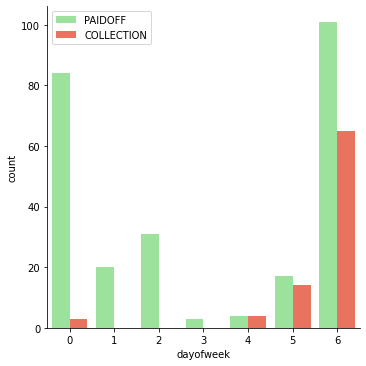

In [6]:
# look at the day of the week people get the loan
sns.catplot(data=df, x="dayofweek", hue="loan_status", kind="count", palette=("lightgreen","tomato"), legend=False)
plt.legend(loc='upper left')
plt.show()

Because the weekend seems to be relevant to identify loans in collection, I create another dummy variable, weekend

In [7]:
# create weekend feature
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
# removing effective date
del df['effective_date']
# removing due date
del df['due_date']
# look at the new dataset
df.head()

,loan_status,Principal,terms,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,45,High School or Below,male,3,0
2,PAIDOFF,1000,30,33,Bachelor,female,3,0
3,PAIDOFF,1000,15,27,college,male,3,0
4,PAIDOFF,1000,30,28,college,female,4,1
6,PAIDOFF,1000,30,29,college,male,4,1


In [8]:
df.shape

(346, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 399
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   loan_status  346 non-null    object
 1   Principal    346 non-null    int64 
 2   terms        346 non-null    int64 
 3   age          346 non-null    int64 
 4   education    346 non-null    object
 5   Gender       346 non-null    object
 6   dayofweek    346 non-null    int64 
 7   weekend      346 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 34.3+ KB


## Exploratory Data Analysis

In [10]:
# look at numeric and categorical variables separately
df_num = df[['Principal', 'age', 'dayofweek']]
df_cat = df[['terms', 'education', 'Gender', 'weekend']]

### Numerical features

In [11]:
# descriptive statistics
df_num.describe()

,Principal,age,dayofweek
count,346.000000,346.000000,346.000000
mean,943.641618,30.939306,3.682081
std,109.425530,6.039418,2.614912
min,300.000000,18.000000,0.000000
25%,900.000000,27.000000,0.250000
50%,1000.000000,30.000000,5.000000
75%,1000.000000,35.000000,6.000000
max,1000.000000,51.000000,6.000000


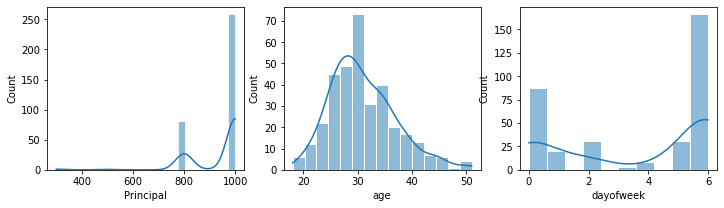

In [12]:
# histograms
fig, axes = plt.subplots(1, 3, figsize=(12,3))

sns.histplot(ax=axes[0], data=df, x='Principal', edgecolor="white", kde=True)
sns.histplot(ax=axes[1], data=df, x='age', edgecolor="white", kde=True)
sns.histplot(ax=axes[2], data=df, x='dayofweek', edgecolor="white", kde=True)
plt.show()

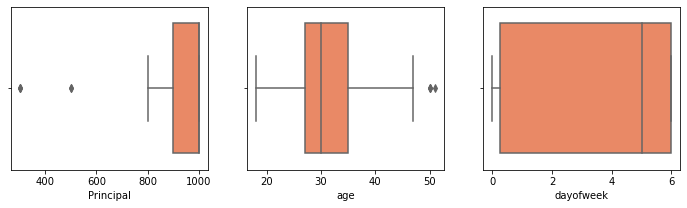

In [13]:
# boxplots
fig, axes = plt.subplots(1, 3, figsize=(12,3))

sns.boxplot(ax=axes[0], data=df, x='Principal', color="coral")
sns.boxplot(ax=axes[1], data=df, x='age', color="coral")
sns.boxplot(ax=axes[2], data=df, x='dayofweek', color="coral")
plt.show()

fig.savefig("boxplot.png", bbox_inches='tight')

<AxesSubplot:>

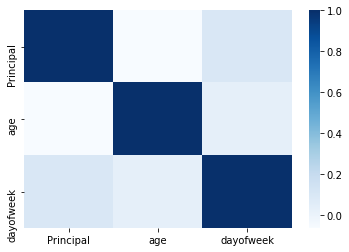

In [14]:
# correlation matrix
sns.heatmap(df_num.corr(), cmap="Blues")

### Categorical features

In [15]:
# terms frequency
terms_f = df['terms'].value_counts()
terms_f.to_frame()

,terms
30,184
15,148
7,14


In [16]:
# education frequency
education_f = df['education'].value_counts()
education_f.to_frame()

,education
High School or Below,151
college,149
Bachelor,44
Master or Above,2


In [17]:
# gender frequency
gender_f = df['Gender'].value_counts()
gender_f.to_frame()

,Gender
male,294
female,52


In [18]:
# weekend frequency
weekend_f = df['weekend'].value_counts()
weekend_f.to_frame()

,weekend
1,205
0,141


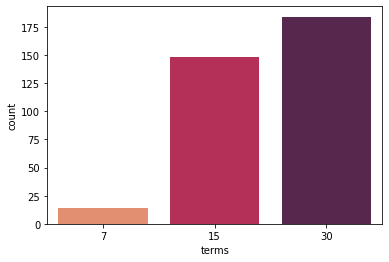

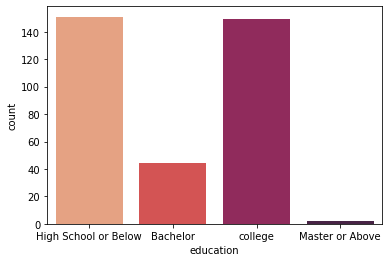

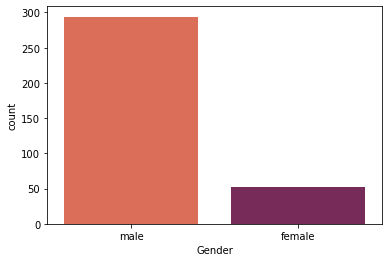

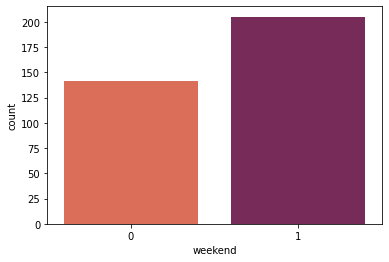

In [19]:
# barplots
for i in df_cat.columns:
    sns.countplot(data=df, x=i, palette="rocket_r")
    plt.show()

### Target Variable

In [20]:
# frequency
c = df['loan_status'].value_counts()
c.to_frame()

,loan_status
PAIDOFF,260
COLLECTION,86


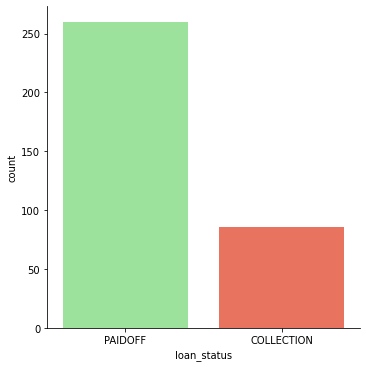

In [21]:
# plot
sns.catplot(data=df, x="loan_status", kind="count", palette=("lightgreen","tomato"), legend=False)
plt.show()

### Relationship between the target variable and features

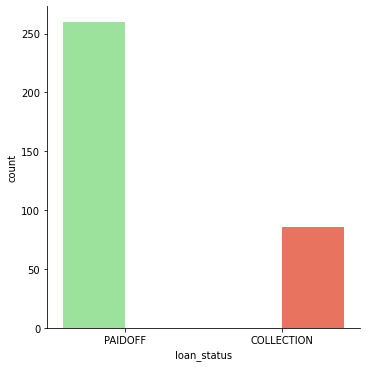

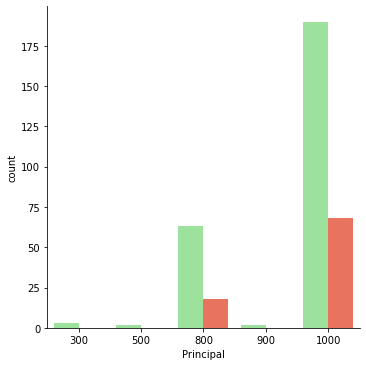

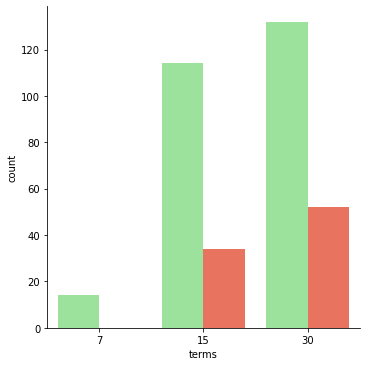

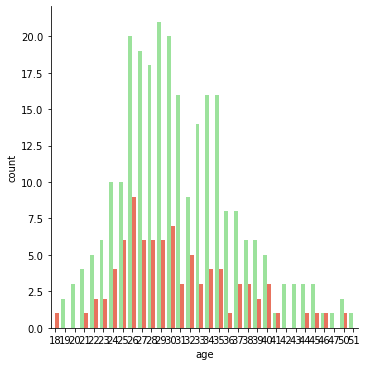

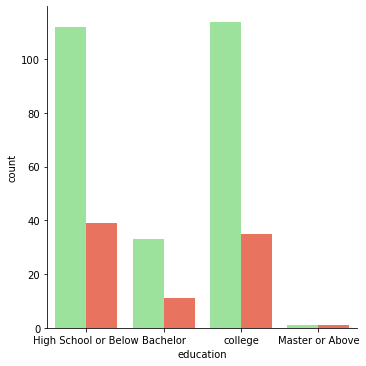

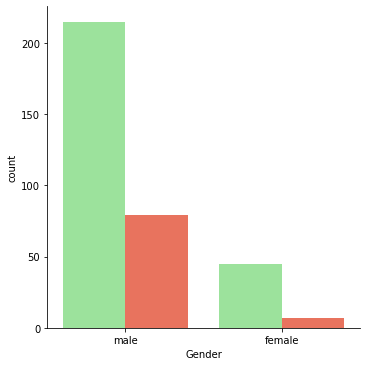

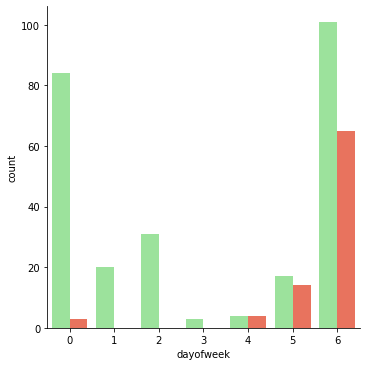

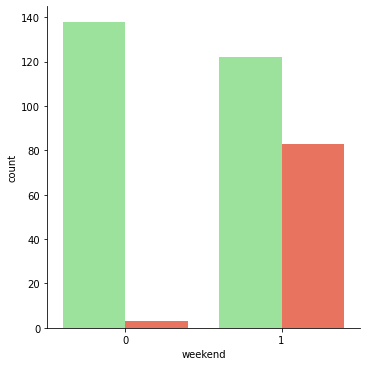

In [22]:
for i in df.columns:
    sns.catplot(data=df, x=i, hue="loan_status", kind="count", palette=("lightgreen","tomato"), legend=False)
    plt.show()

### Feature Engineering

In [23]:
# converting gender into dummy variable
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,45,High School or Below,0,3,0
2,PAIDOFF,1000,30,33,Bachelor,1,3,0
3,PAIDOFF,1000,15,27,college,0,3,0
4,PAIDOFF,1000,30,28,college,1,4,1
6,PAIDOFF,1000,30,29,college,0,4,1


In [24]:
# one hot encoding for education, dropping dayofweek and master or above for poor significance
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,45,0,0,0,1,0
2,1000,30,33,1,0,1,0,0
3,1000,15,27,0,0,0,0,1
4,1000,30,28,1,1,0,0,1
6,1000,30,29,0,1,0,0,1


In [25]:
# X and y
X = Feature
y = df['loan_status'].values

In [26]:
# standardize the data
X= preprocessing.StandardScaler().fit(X).transform(X)

## Modeling

In [27]:
# split the train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


Load and pre-process the test set for out of sample evaluation

In [28]:
# load validation set
test_df = pd.read_csv('loan_test_set.csv', index_col=0)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bachelor,female
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bachelor,male


In [29]:
# shape
test_df.shape

(54, 8)

In [30]:
# convert to datetime
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

In [31]:
# dayofweek column
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

In [32]:
# weekend column
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

In [33]:
# set gender to male=0/female=1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [34]:
# one hot encoding
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

In [35]:
# set X & y and normalize
test_X = Feature
test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_y = test_df['loan_status'].values

## Logistic Regression

In [36]:
# import module
from sklearn.linear_model import LogisticRegression

In [37]:
# fit model, solver=liblinear
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

In [40]:
# prediction in the train set
yhat_lr = LR.predict(X_test)
print("Logit's Accuracy: ", metrics.accuracy_score(y_test, yhat_lr))

Logit's Accuracy:  0.6857142857142857


### Validation

In [41]:
# prediction on the test set
yhat_logit = LR.predict(test_X)

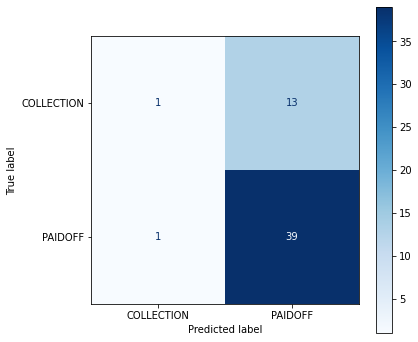

In [42]:
# confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(LR, test_X, test_y, cmap='Blues', ax=ax)
plt.show()

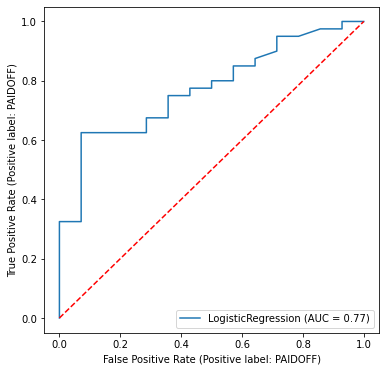

In [43]:
# roc curve
fig, ax = plt.subplots(figsize=(6,6))
plot_roc_curve(LR, test_X, test_y, ax=ax)
ax.plot([0,1],[0,1], linestyle='--', color='r')
plt.show()

In [44]:
# metrics
print(accuracy_score(test_y, yhat_logit))
print(precision_score(test_y, yhat_logit, pos_label='PAIDOFF'))
print(recall_score(test_y, yhat_logit, pos_label='PAIDOFF'))
print(f1_score(test_y, yhat_logit, pos_label='PAIDOFF'))

0.7407407407407407
0.75
0.975
0.8478260869565216


In [45]:
# plus, specificity = 1/14 = 0,07

In [46]:
# extract important features
# as expected, most significant variable is "weekend" with -0,34
coeffs = LR.coef_
coeffs

array([[-0.03558819, -0.06048198,  0.06080593,  0.06652829, -0.34334129,
         0.00967832, -0.0119959 ,  0.0014945 ]])

## Naive Bayes Classifier

In [47]:
#import module
from sklearn.naive_bayes import GaussianNB

In [48]:
#fit model, solver=liblinear
NB = GaussianNB().fit(X_train,y_train)

In [49]:
#prediction in the train set
yhat_nb = NB.predict(X_test)
print("Logit's Accuracy: ", metrics.accuracy_score(y_test, yhat_nb))

Logit's Accuracy:  0.6


### Validation

In [50]:
# prediction on the test set
yhat_nb = NB.predict(test_X)

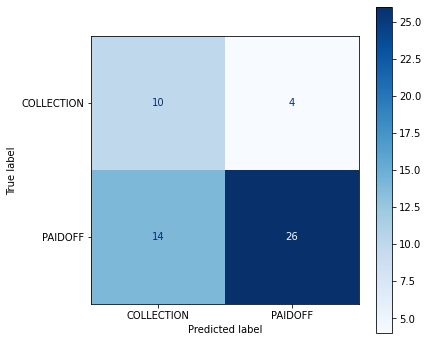

In [51]:
# confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(NB, test_X, test_y, cmap='Blues', ax=ax)
plt.show()

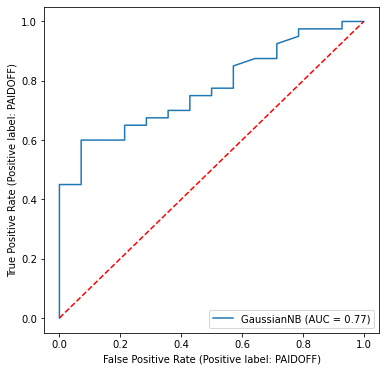

In [52]:
# roc curve
fig, ax = plt.subplots(figsize=(6,6))
plot_roc_curve(NB, test_X, test_y, ax=ax)
ax.plot([0,1],[0,1], linestyle='--', color='r')
plt.show()

In [53]:
# metrics
print(accuracy_score(test_y, yhat_nb))
print(precision_score(test_y, yhat_nb, pos_label='PAIDOFF'))
print(recall_score(test_y, yhat_nb, pos_label='PAIDOFF'))
print(f1_score(test_y, yhat_nb, pos_label='PAIDOFF'))

0.6666666666666666
0.8666666666666667
0.65
0.7428571428571429


In [54]:
# specificity = 10/14 = 0,71

## K Nearest Neighbors

In [55]:
# import module
from sklearn.neighbors import KNeighborsClassifier

In [56]:
# find the best K with Cross-validation, Accuracy as metric
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


In [57]:
# fit the model
k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

In [58]:
# prediction in the train set
yhat_knn = neigh.predict(X_test)
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_knn))

Test set Accuracy:  0.7857142857142857


### Validation

In [59]:
# prediction on the test set
yhat_knn = neigh.predict(test_X)

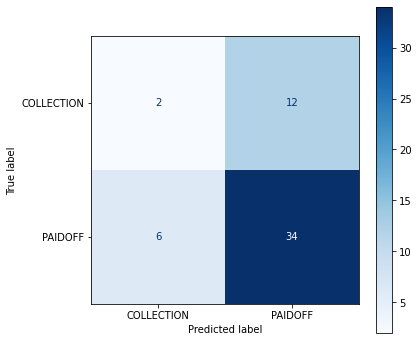

In [60]:
# confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(neigh, test_X, test_y, cmap='Blues', ax=ax)
plt.show()

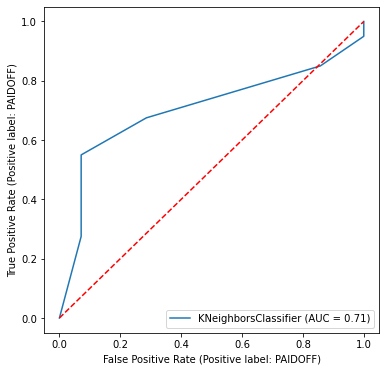

In [61]:
# roc curve
fig, ax = plt.subplots(figsize=(6,6))
plot_roc_curve(neigh, test_X, test_y, ax=ax)
ax.plot([0,1],[0,1], linestyle='--', color='r')
plt.show()

In [62]:
# metrics
print(accuracy_score(test_y, yhat_knn))
print(precision_score(test_y, yhat_knn, pos_label='PAIDOFF'))
print(recall_score(test_y, yhat_knn, pos_label='PAIDOFF'))
print(f1_score(test_y, yhat_knn, pos_label='PAIDOFF'))

0.6666666666666666
0.7391304347826086
0.85
0.7906976744186046


In [63]:
# specificity = 2/14 = 0,14

## Support Vector Machine

In [64]:
# import module
from sklearn import svm

In [65]:
# fit model, kernel function=radial basis function
svmodel = svm.SVC(kernel='rbf')
svmodel.fit(X_train, y_train) 

SVC()

In [66]:
#prediction in the train set
yhat_svm = svmodel.predict(X_test)
print("SVM's Accuracy: ", metrics.accuracy_score(y_test, yhat_svm))

SVM's Accuracy:  0.7428571428571429


### Validation

In [67]:
# prediction on the test set
yhat_svm = svmodel.predict(test_X)

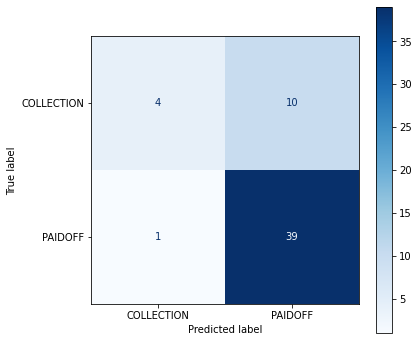

In [68]:
# confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(svmodel, test_X, test_y, cmap='Blues', ax=ax)
plt.show()

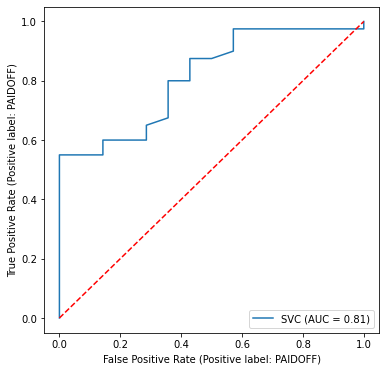

In [69]:
# roc curve
fig, ax = plt.subplots(figsize=(6,6))
plot_roc_curve(svmodel, test_X, test_y, ax=ax)
ax.plot([0,1],[0,1], linestyle='--', color='r')
plt.show()

In [70]:
# metrics
print(accuracy_score(test_y, yhat_svm))
print(precision_score(test_y, yhat_svm, pos_label='PAIDOFF'))
print(recall_score(test_y, yhat_svm, pos_label='PAIDOFF'))
print(f1_score(test_y, yhat_svm, pos_label='PAIDOFF'))

0.7962962962962963
0.7959183673469388
0.975
0.8764044943820225


In [71]:
# specificity = 4/14 = 0,29

## Decision Tree

In [72]:
# import module
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="entropy")
dtree = dtree.fit(X_train,y_train)

In [73]:
# find the best max depth with cv
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': range(1, dtree.tree_.max_depth+1, 2)}

gr = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=-1) 
gr=gr.fit(X_train,y_train)

In [74]:
gr.best_estimator_.tree_.max_depth

1

In [75]:
# find the best max depth with Cross-validation, Accuracy as metric
nodes = 10
mean_acc = np.zeros((nodes-1))
std_acc = np.zeros((nodes-1))

for n in range(1,nodes):
    
    #Train Model and Predict  
    tree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    yhat_tree=tree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_tree)

    
    std_acc[n-1]=np.std(yhat_tree==y_test)/np.sqrt(yhat.shape[0])

mean_acc
print( "The best accuracy was with", mean_acc.max(), "with n=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with n= 1


In [76]:
#NOTE: I do not set a max_depth, because with maxdepth=1 out of sample the model doesn't classify, 
# just predicts 54/54 paidoff. Definitely need to enlarge sample with more feature to make it better
tree = DecisionTreeClassifier(criterion="entropy").fit(X_train,y_train)

### Validation

In [77]:
# prediction on the test set
yhat_tree = tree.predict(test_X)

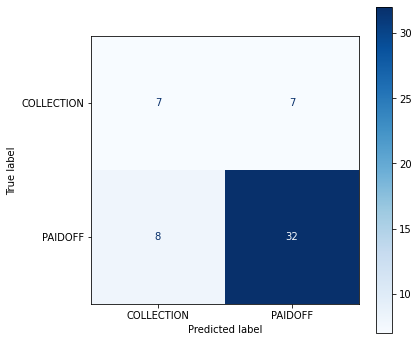

In [78]:
# confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(tree, test_X, test_y, cmap='Blues', ax=ax)
plt.show()

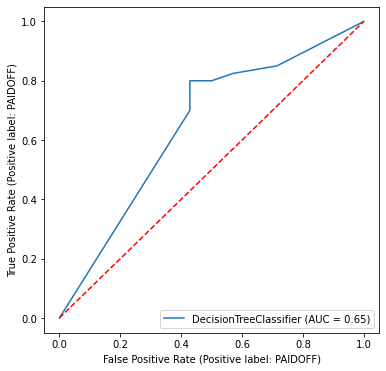

In [79]:
# roc curve
fig, ax = plt.subplots(figsize=(6,6))
plot_roc_curve(tree, test_X, test_y, ax=ax)
ax.plot([0,1],[0,1], linestyle='--', color='r')
plt.show()

In [80]:
# metrics
print(accuracy_score(test_y, yhat_tree))
print(precision_score(test_y, yhat_tree, pos_label='PAIDOFF'))
print(recall_score(test_y, yhat_tree, pos_label='PAIDOFF'))
print(f1_score(test_y, yhat_tree, pos_label='PAIDOFF'))

0.7222222222222222
0.8205128205128205
0.8
0.810126582278481


In [81]:
# specificity = 7/14 = 0,50

In [82]:
# feature importances
tree.feature_importances_

array([0.05722648, 0.05262181, 0.40281521, 0.07024048, 0.33019386,
       0.00377389, 0.03550107, 0.0476272 ])

## Random Forest

In [83]:
# import module
from sklearn.ensemble import RandomForestClassifier

In [84]:
# fit the model, 50 trees 
rf = RandomForestClassifier(n_estimators=50, criterion="entropy")
rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [85]:
# prediction in the train set
yhat_rf = rf.predict(X_test)
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_rf))

Test set Accuracy:  0.7142857142857143


### Validation

In [86]:
# prediction on the test set
yhat_rf = rf.predict(test_X)

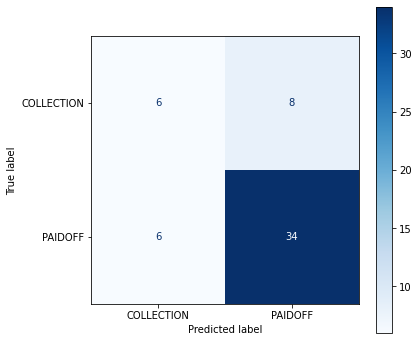

In [87]:
# confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(rf, test_X, test_y, cmap='Blues', ax=ax)
plt.show()

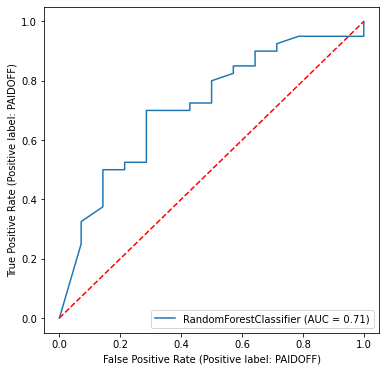

In [88]:
# roc curve
fig, ax = plt.subplots(figsize=(6,6))
plot_roc_curve(rf, test_X, test_y, ax=ax)
ax.plot([0,1],[0,1], linestyle='--', color='r')
plt.show()

In [89]:
# metrics
print(accuracy_score(test_y, yhat_rf))
print(precision_score(test_y, yhat_rf, pos_label='PAIDOFF'))
print(recall_score(test_y, yhat_rf, pos_label='PAIDOFF'))
print(f1_score(test_y, yhat_rf, pos_label='PAIDOFF'))

0.7407407407407407
0.8095238095238095
0.85
0.8292682926829269


In [90]:
# specificity = 6/14 = 0,43

In [91]:
# feature importances
rf.feature_importances_

array([0.03782326, 0.07223525, 0.49458643, 0.03891371, 0.293788  ,
       0.01846506, 0.02529782, 0.01889047])

## Gradient Boosting

In [92]:
# import module
from sklearn.ensemble import GradientBoostingClassifier

In [93]:
# fit the model, keeping deafault parameters: n_estimators=100, learning_rate=0.1, subsample=1 
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)

GradientBoostingClassifier()

In [94]:
# prediction in the train set
yhat_gb = gb.predict(X_test)
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_gb))

Test set Accuracy:  0.7571428571428571


### Validation

In [95]:
# prediction on the test set
yhat_gb = gb.predict(test_X)

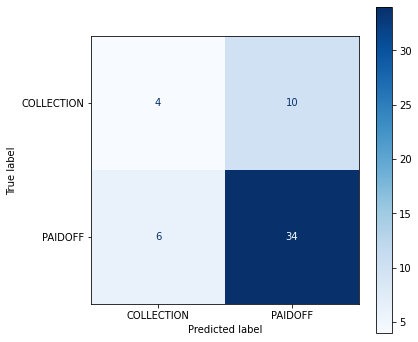

In [96]:
# confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(gb, test_X, test_y, cmap='Blues', ax=ax)
plt.show()

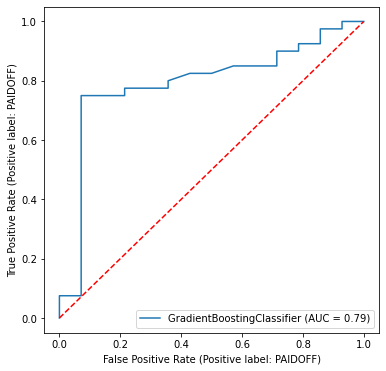

In [97]:
# roc curve
fig, ax = plt.subplots(figsize=(6,6))
plot_roc_curve(gb, test_X, test_y, ax=ax)
ax.plot([0,1],[0,1], linestyle='--', color='r')
plt.show()

In [98]:
# metrics
print(accuracy_score(test_y, yhat_gb))
print(precision_score(test_y, yhat_gb, pos_label='PAIDOFF'))
print(recall_score(test_y, yhat_gb, pos_label='PAIDOFF'))
print(f1_score(test_y, yhat_gb, pos_label='PAIDOFF'))

0.7037037037037037
0.7727272727272727
0.85
0.8095238095238095


In [99]:
# specificity = 4/14 = 0,28

In [100]:
# feature importances
gb.feature_importances_

array([0.02442388, 0.09464065, 0.22555071, 0.03014681, 0.55497499,
       0.01686218, 0.02602523, 0.02737556])

## XGBoost

In [101]:
# import module
import xgboost as xgb

In [102]:
# setting parameters equal to gradient boosting for comparison
xgb = xgb.XGBClassifier(learning_rate = 0.1, subsample=1, n_estimators = 100)
xgb.fit(X_train,y_train)

[19:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Daniele\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
# prediction in the train set
yhat_xgb = xgb.predict(X_test)
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_xgb))

Test set Accuracy:  0.7142857142857143


### Validation

In [104]:
# prediction on the test set
yhat_xgb = xgb.predict(test_X)

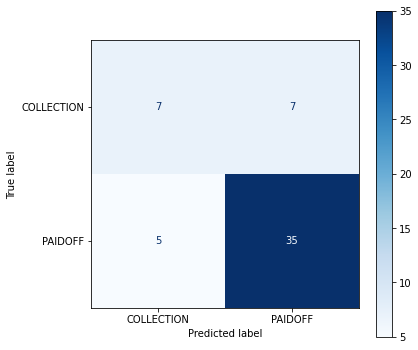

In [105]:
# confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(xgb, test_X, test_y, cmap='Blues', ax=ax)
plt.show()

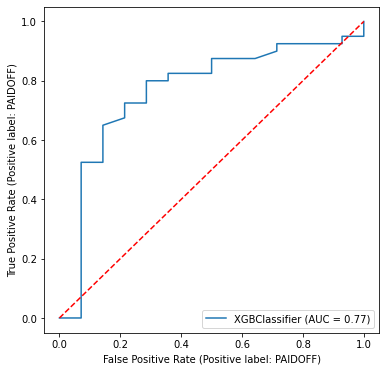

In [106]:
# roc curve
fig, ax = plt.subplots(figsize=(6,6))
plot_roc_curve(xgb, test_X, test_y, ax=ax)
ax.plot([0,1],[0,1], linestyle='--', color='r')
plt.show()

In [107]:
# metrics
print(accuracy_score(test_y, yhat_xgb))
print(precision_score(test_y, yhat_xgb, pos_label='PAIDOFF'))
print(recall_score(test_y, yhat_xgb, pos_label='PAIDOFF'))
print(f1_score(test_y, yhat_xgb, pos_label='PAIDOFF'))

0.7777777777777778
0.8333333333333334
0.875
0.8536585365853658


In [108]:
# specificity = 7/14 = 0,5

In [109]:
# feature importances
xgb.feature_importances_

array([0.02333624, 0.05013738, 0.04085001, 0.05696869, 0.71062744,
       0.0364198 , 0.03381347, 0.04784695], dtype=float32)

## ROC Curve Comparison

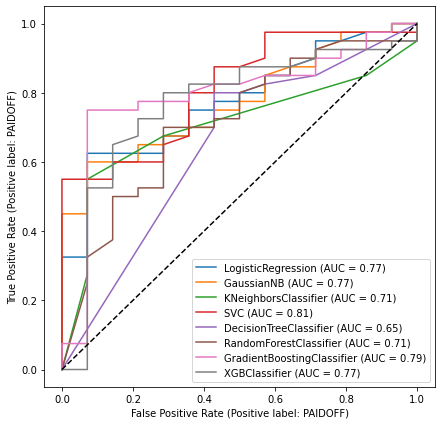

In [110]:
fig, ax = plt.subplots(figsize=(7,7))
plot_roc_curve(LR, test_X, test_y, ax=ax) # logistic regression
plot_roc_curve(NB, test_X, test_y, ax=ax) # naive bayes
plot_roc_curve(neigh, test_X, test_y, ax=ax) # k nearest neighbors
plot_roc_curve(svmodel, test_X, test_y, ax=ax) # support vector machine
plot_roc_curve(tree, test_X, test_y, ax=ax) # decision tree
plot_roc_curve(rf, test_X, test_y, ax=ax) # random forest
plot_roc_curve(gb, test_X, test_y, ax=ax) # gradient boosting
plot_roc_curve(xgb, test_X, test_y, ax=ax) # xgboost
ax.plot([0,1],[0,1], linestyle='--', color='k')
plt.show()